<a href="https://colab.research.google.com/github/NITHISHM2410/Alzheimers-Detection-and-Classification/blob/main/Driver-Drowsiness-Detection/Driver_Drowsiness_Detection/NoteBooks/driver_drowsiness_detection_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mtcnn
import cv2
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.0 MB/s eta 0:00:00


In [4]:
detector = MTCNN()

In [40]:
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)

    return img

In [41]:
def return_boxes(result_list):
    #print(result_list)
    for result in result_list:
        x, y, width, height = result['box']
        height = height / 2
        eye1 = Rectangle((x, y), width / 2, height, fill=False, color='red')
        eye2 = Rectangle(((x + (width / 2)), y), width / 2, height, fill=False, color='red')
        return (eye1, eye2)

In [59]:
def extract_eye(image, img, image_matrix_given=True):
    if image_matrix_given == False:
        image = pyplot.imread(img)
    img = return_boxes(detector.detect_faces(image))
    print("++")
    if img is None:
        return False
    left = img[0]
    x = int(left.xy[0])
    y = int(left.xy[1])
    xw = int(left.xy[0] + left._width)
    yh = int(left.xy[1] + left._height)
    l_eye = image[y:yh, x:xw]
    l_eye = cv2.resize(l_eye, (256, 256))
    l_eye = sharpen(l_eye)
    l_eye = tf.image.rgb_to_grayscale(l_eye)

    right = img[1]
    x = int(right.xy[0])
    y = int(right.xy[1])
    xw = int(right.xy[0] + right._width)
    yh = int(right.xy[1] + right._height)
    r_eye = image[y:yh, x:xw]
    r_eye = cv2.resize(r_eye, (256, 256))
    r_eye = sharpen(r_eye)
    r_eye = tf.image.rgb_to_grayscale(r_eye)

    return ((l_eye, r_eye), (left, right))


In [56]:
def produce_eye_output(model, inputs):
    outputs = model(inputs)
    print("Left Eye Confidence(closed and open) :",outputs[0])
    print("Right Eye Confidence(closed and open) :",outputs[1])
    if tf.argmax(outputs[0]) == 0 or tf.argmax(outputs[1]) == 0:
        return True
    else:
        return False
def eye_classification(l_eye, r_eye, model):
    l_eye = tf.expand_dims(l_eye, axis=0)
    r_eye = tf.expand_dims(r_eye, axis=0)
    #print(l_eye.shape,r_eye.shape)
    inputs = tf.concat([l_eye, r_eye], axis=0)
    #print(inputs.shape)
    output = produce_eye_output(model, inputs)
    if output:
        return True


In [57]:
def yawn_detection(face, model):
    inputs = cv2.resize(face, (256, 256))
    inputs = tf.expand_dims(inputs, axis=0)
    output = model(inputs)
    print("Yawn Confidence(closed and open) :",output)
    output = np.argmax(np.round(np.squeeze(output)))
    return output


In [45]:
def drowsiness(image,markings = True):
    yawn = yawn_detection(image, models[1])
    eyes = extract_eye(image, "")
    if not eyes:
        eye = False
    else:
        eye_class = eyes[0]
        markings = eyes[1]
        eye = eye_classification(eye_class[0], eye_class[1], models[0])
    if yawn == 0 :
        print("Driver is Yawning")
    if eye == True:
        print("Driver's eyes are closed")
    if markings is not False:
        return markings


In [46]:
def get_models_ready():
    eye_model = tf.keras.models.load_model("/content/drive/MyDrive/eye_classification_2.h5")
    yawn_model = tf.keras.models.load_model("/content/drive/MyDrive/yawn_detection.h5")
    return eye_model, yawn_model

models = get_models_ready()

Yawn Confidence(closed and open) : tf.Tensor([[9.9999428e-01 5.7441894e-06]], shape=(1, 2), dtype=float32)
1/1 [==============================] - 0s 46ms/step
++
Left Eye Confidence(closed and open) : tf.Tensor([0.87237537 0.12762459], shape=(2,), dtype=float32)
Right Eye Confidence(closed and open) : tf.Tensor([0.9467568 0.0532432], shape=(2,), dtype=float32)
Driver is Yawning
Driver's eyes are closed


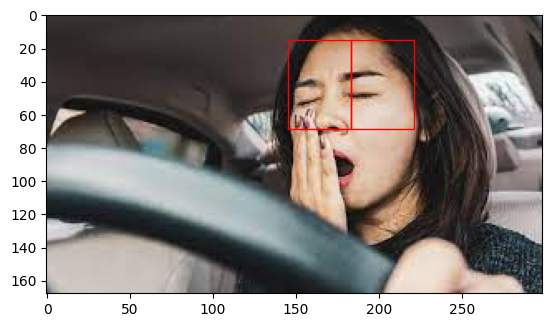

In [60]:
for frame in range(0,1):
    frame = pyplot.imread("download.jpg")
    if frame.shape[-1] ==  4:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
    markings = drowsiness(frame)
    pyplot.imshow(frame)
    ax = pyplot.gca()
    if markings is not None :
        ax.add_patch(markings[0])
        ax.add_patch(markings[1])
    pyplot.show()
